<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/lowering_convolutional_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [1]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 512kB 46.8MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 3.8MB 48.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=0d95fe8700412b41cd455b03c345326d767f7f8599a98f0d989151e75501c680
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [2]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [3]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

Cloning into 'ml-data'...
remote: Enumerating objects: 13236, done.
remote: Total 13236 (delta 0), reused 0 (delta 0), pack-reused 13236
Receiving objects: 100% (13236/13236), 64.73 MiB | 33.41 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [4]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [5]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/1824.jpg


## 2. Training data

In [6]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=20

In [7]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [8]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [9]:
model = Sequential()
model.add(Conv2D(64, (2,2), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', tf.keras.metrics.Precision()])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 99, 64)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        18464     
_________________________________________________________________
dropout (Dropout)            (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 95, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 8)         1

## 3. Train the model

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='loss', patience=3)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [12]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/20
311/311 [==============================] - 21s 68ms/step - loss: 0.1799 - acc: 0.9285 - precision: 0.9087 - val_loss: 0.1013 - val_acc: 0.9722 - val_precision: 0.9653
Epoch 2/20
311/311 [==============================] - 14s 44ms/step - loss: 0.0822 - acc: 0.9697 - precision: 0.9610 - val_loss: 0.1420 - val_acc: 0.9545 - val_precision: 0.9200
Epoch 3/20
 54/311 [====>.........................] - ETA: 8s - loss: 0.1145 - acc: 0.9514 - precision: 0.9114
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
311/311 [==============================] - 14s 44ms/step - loss: 0.0681 - acc: 0.9781 - precision: 0.9725 - val_loss: 0.1152 - val_acc: 0.9511 - val_precision: 0.9114
Epoch 4/20
311/311 [==============================] - 14s 44ms/step - loss: 0.0468 - acc: 0.9820 - precision: 0.9764 - val_loss: 0.0495 - val_acc: 0.9835 - val_precision: 0.9794
Epoch 5/20
311/311 [==============================] - 14s 44ms/step - loss: 0.0397 - acc: 0.9857 - precision

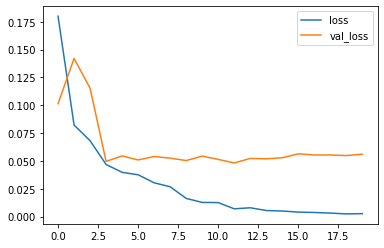

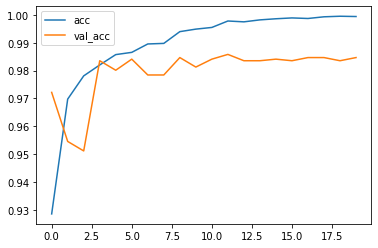

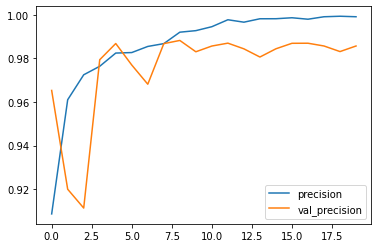

In [13]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision', 'val_precision']].plot()

In [17]:
loss_mean = loss.mean()
loss_mean

loss             0.029684
acc              0.989102
precision        0.985991
val_loss         0.062916
val_acc          0.979517
val_precision    0.975816
lr               0.000342
dtype: float64

In [15]:
print("Epochs: ", EPOCHS)
print("Train time: ", endTime, "seconds") 

Epochs:  20
Train time:  279.79741764068604 seconds


In [18]:
print("| ALGORITMO | {} | {} |  {} |   {} |  {} |      {} | {} |      {} |   {} |     |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision, loss_mean.val_precision, loss_mean.lr, len(model.history.epoch), endTime))


| ALGORITMO | 0.9891022354364395 | 0.029684181925849602 |  0.979517039656639 |   0.06291594725548127 |  0.9859909981489181 |      0.9758163005113601 | 0.0003421875162530341 |      20 |   279.79741764068604 |     |
